## Import Packages Required for Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import psutil
import itertools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, learning_curve 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC, SVR, LinearSVC

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score,roc_auc_score, roc_curve, average_precision_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import precision_recall_curve

In [2]:
np.random.seed(4077010)#set seed as my gtid, this was done in ML4T which I thought was clever

## Import Required Datasets


In [3]:
hotel = pd.read_csv('hotel_bookings.csv')

In [4]:
accidents = pd.read_csv('US_Accidents_March23.csv')

## Preliminary Spot Check / Get a Feel For the Data

In [5]:
hotel.shape
print(hotel.head())

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

In [6]:
accidents.shape
print(accidents.head())

    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          F

In [7]:
#Find Columns With High Cardinality - doing this after realizing I forgot to handle this and having dimensionality issues which is why this is sort of out of order
for col in hotel.select_dtypes(include=['object']).columns:
    unique = hotel[col].nunique()
    print(f'{col}: {unique:,} values')

hotel: 2 values
arrival_date_month: 12 values
meal: 5 values
country: 177 values
market_segment: 8 values
distribution_channel: 5 values
reserved_room_type: 10 values
assigned_room_type: 12 values
deposit_type: 3 values
customer_type: 4 values
reservation_status: 3 values
reservation_status_date: 926 values


## Data Preprocessing 

#### Drop columns that can cause data leakage, clean up target data.

In [8]:
hotel_clean = hotel.copy()

In [9]:
hotel_clean = hotel_clean.drop(columns = ['reservation_status', 'reservation_status_date'])

hotel_clean = hotel_clean.dropna(subset = ['is_canceled'])

In [10]:
for col in hotel_clean.select_dtypes(include=['object']).columns:
    unique = hotel_clean[col].nunique()
    print(f'{col}: {unique:,} values')

hotel: 2 values
arrival_date_month: 12 values
meal: 5 values
country: 177 values
market_segment: 8 values
distribution_channel: 5 values
reserved_room_type: 10 values
assigned_room_type: 12 values
deposit_type: 3 values
customer_type: 4 values


In [11]:
hotel_clean = hotel_clean.apply(lambda col: col.astype('float32') if col.dtype == 'float64' else col)
#from copilot search via microsoft edge accessed on 9/8/2025, searching "current copilot search version" yields the version: 1.25054.80.0

print(hotel_clean.head())
print(hotel_clean.dtypes)

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0        

In [12]:
hotel_x = hotel_clean.drop(columns = ['is_canceled'])
hotel_y = hotel_clean['is_canceled']

#Define X and Y space

In [13]:
#split data before any preprocessing to prevent leakage
hotel_x_train, hotel_x_test, hotel_y_train, hotel_y_test = train_test_split(
    hotel_x, hotel_y, test_size=0.2, stratify=hotel_y, random_state=4077010
)    


hotel_x_train_clean = hotel_x_train.copy()
hotel_x_test_clean = hotel_x_test.copy()

for col in hotel_x.select_dtypes(include=['number']).columns.tolist():
    hotel_x_train_clean[col] = hotel_x_train_clean[col].fillna(hotel_x_train_clean[col].median()) #replace numeric data with nans with median
    hotel_x_test_clean[col] = hotel_x_test_clean[col].fillna(hotel_x_train_clean[col].median())
        
for col in hotel_x.select_dtypes(include=['object']).columns.tolist():
    hotel_x_train_clean[col] = hotel_x_train_clean[col].fillna('Unknown') #replace categorical data with "Unknown"
    hotel_x_test_clean[col] = hotel_x_test_clean[col].fillna('Unknown')

low_cardinality_cols = [] #Used claude sonnet 4 on 9/11/2025 to fix encoding for high cardinality
high_cardinality_cols = []
cardinality_threshold = 20 

for col in hotel_x_train_clean.select_dtypes(include=['object']).columns:
    unique_count = hotel_x_train_clean[col].nunique()
    if unique_count <= cardinality_threshold:
        low_cardinality_cols.append(col)
    else:
        high_cardinality_cols.append(col)


numerical_cols = hotel_x_train_clean.select_dtypes(include=['number']).columns.tolist()


hotel_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), low_cardinality_cols),
        ('cat_high', TargetEncoder(target_type='binary', smooth='auto'), high_cardinality_cols) 
    ]
)


hotel_x_train_pro = hotel_preprocessor.fit_transform(hotel_x_train_clean, hotel_y_train)  
hotel_x_train_pro = pd.DataFrame(hotel_x_train_pro)
hotel_x_test_pro = hotel_preprocessor.transform(hotel_x_test_clean)
hotel_x_test_pro = pd.DataFrame(hotel_x_test_pro)

print("Training Set: ")
print(hotel_x_train_pro.head())
print("Test Set:")
print(hotel_x_test_pro.head())

Training Set: 
         0         1         2         3         4         5         6   \
0  0.320263 -0.221062  0.500919  0.133965  0.073963  0.785127  0.250594   
1  1.031986  1.191626  0.354087 -0.436392  1.073878 -0.262236  0.250594   
2  0.554382  1.191626  0.133840  0.248037 -0.925951  0.261446  0.250594   
3  0.114237  1.191626 -0.673734 -1.234892  1.073878  1.308809  0.250594   
4 -0.934619 -0.221062  0.794582 -0.436392  0.073963  0.261446  0.250594   

         7         8         9   ...   61   62   63   64   65   66   67   68  \
0 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4 -0.261131 -0.079808 -0.181068  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

    69        70  
0  0.0  0.184325  
1  0.0  0.56653

D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Training and testing sets have matching dimensionality - cool!

#### Hotel data should now be properly formatted, on to accident data:

In [14]:
accidents_clean = accidents.copy()
accidents_clean = accidents_clean.dropna(subset = ['Severity'])
accidents_clean = accidents_clean.drop(columns=['End_Time', 'Weather_Timestamp'])

In [15]:
accidents_clean = accidents_clean.apply(lambda col: col.astype('float32') if col.dtype == 'float64' else col)
#from copilot search via microsoft edge accessed on 9/8/2025, searching "current copilot search version" yields the version: 1.25054.80.0

print(accidents_clean.head())
print(accidents_clean.dtypes)

    ID   Source  Severity           Start_Time  Start_Lat  Start_Lng  End_Lat  \
0  A-1  Source2         3  2016-02-08 05:46:00  39.865147 -84.058723      NaN   
1  A-2  Source2         2  2016-02-08 06:07:59  39.928059 -82.831184      NaN   
2  A-3  Source2         2  2016-02-08 06:49:27  39.063148 -84.032608      NaN   
3  A-4  Source2         3  2016-02-08 07:23:34  39.747753 -84.205582      NaN   
4  A-5  Source2         2  2016-02-08 07:39:07  39.627781 -84.188354      NaN   

   End_Lng  Distance(mi)                                        Description  \
0      NaN          0.01  Right lane blocked due to accident on I-70 Eas...   
1      NaN          0.01  Accident on Brice Rd at Tussing Rd. Expect del...   
2      NaN          0.01  Accident on OH-32 State Route 32 Westbound at ...   
3      NaN          0.01  Accident on I-75 Southbound at Exits 52 52B US...   
4      NaN          0.01  Accident on McEwen Rd at OH-725 Miamisburg Cen...   

   ... Roundabout Station   Stop Traff

In [16]:
accidents_x = accidents_clean.drop(columns = ['Severity'])
accidents_y = accidents_clean['Severity']

### Find Columns With High Cardinality

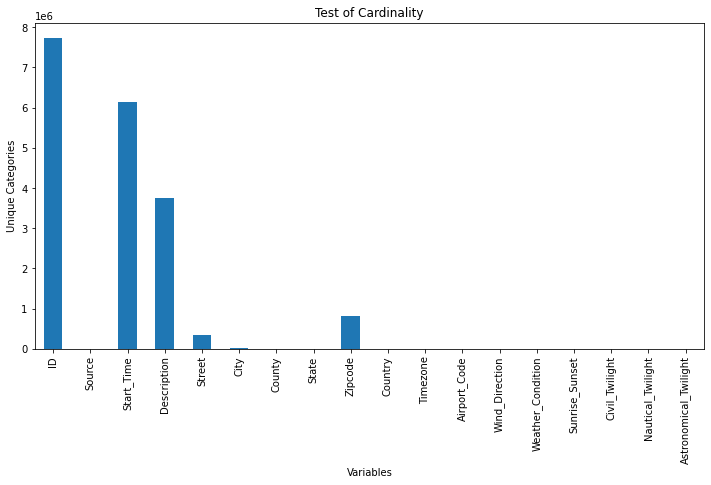

In [17]:
obj = accidents_x.select_dtypes(include=['object'])
obj.nunique().plot.bar(figsize = (12,6))
plt.ylabel('Unique Categories')
plt.xlabel('Variables')
plt.title('Test of Cardinality')
plt.show()

In [18]:
for col in accidents_x.select_dtypes(include=['object']).columns:
    unique = accidents_x[col].nunique()
    print(f'{col}: {unique:,} values')

ID: 7,728,394 values
Source: 3 values
Start_Time: 6,131,796 values
Description: 3,761,578 values
Street: 336,306 values
City: 13,678 values
County: 1,871 values
State: 49 values
Zipcode: 825,094 values
Country: 1 values
Timezone: 4 values
Airport_Code: 2,045 values
Wind_Direction: 24 values
Weather_Condition: 144 values
Sunrise_Sunset: 2 values
Civil_Twilight: 2 values
Nautical_Twilight: 2 values
Astronomical_Twilight: 2 values


In [19]:
#split data before any preprocessing to prevent leakage, copy and paste from above, why duplicate labor?
accidents_x_train, accidents_x_test, accidents_y_train, accidents_y_test = train_test_split(
    accidents_x, accidents_y, test_size=0.2, stratify=accidents_y, random_state=4077010
)    

accidents_x_train_clean = accidents_x_train.copy()
accidents_x_test_clean = accidents_x_test.copy()

for col in accidents_x_train_clean.select_dtypes(include=['number']).columns.tolist():
    accidents_x_train_clean[col] = accidents_x_train_clean[col].fillna(accidents_x_train_clean[col].median()) #replace numeric data with nans with median
    accidents_x_test_clean[col] = accidents_x_test_clean[col].fillna(accidents_x_train_clean[col].median())
        
for col in accidents_x_train_clean.select_dtypes(include=['object']).columns.tolist():
    accidents_x_train_clean[col] = accidents_x_train_clean[col].fillna('Unknown') #replace categorical data with "Unknown"
    accidents_x_test_clean[col] = accidents_x_test_clean[col].fillna('Unknown')

low_cardinality_cols_acc = []#Used claude sonnet 4 on 9/11/2025 to fix encoding for high cardinality
high_cardinality_cols_acc = []
cardinality_threshold_acc = 20 

for col in accidents_x_train_clean.select_dtypes(include=['object']).columns:
    unique_count = accidents_x_train_clean[col].nunique()
    if unique_count <= cardinality_threshold_acc:
        low_cardinality_cols_acc.append(col)
    else:
        high_cardinality_cols_acc.append(col)


numerical_cols_acc = accidents_x_train_clean.select_dtypes(include=['number']).columns.tolist()

accidents_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_acc),
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), low_cardinality_cols_acc),
        ('cat_high', TargetEncoder(target_type='multiclass', smooth='auto'), high_cardinality_cols_acc)     
    ]
)


accidents_x_train_pro = accidents_preprocessor.fit_transform(accidents_x_train_clean, accidents_y_train)
accidents_x_train_pro = pd.DataFrame(accidents_x_train_pro)
accidents_x_test_pro = accidents_preprocessor.transform(accidents_x_test_clean)
accidents_x_test_pro = pd.DataFrame(accidents_x_test_pro)

print("Training Set: ")
print(accidents_x_train_pro.head())
print("Test Set:")
print(accidents_x_test_pro.head())

Training Set: 
         0         1         2         3         4         5         6   \
0  0.861418  1.153133  1.102278  1.256358 -0.219906 -0.463017 -0.321498   
1 -2.029145  0.833392 -2.620126  0.861479  0.013981  0.227953  0.143660   
2 -0.528118  0.452997 -0.011241  0.306023 -0.314469  0.759468  0.867238   
3 -1.527613  0.760906 -1.972245  0.771829 -0.274182  1.131528  1.229027   
4  1.127795  0.387408 -0.011241  0.306023  2.511208 -2.589076 -2.388865   

         7         8         9   ...        60        61        62        63  \
0 -0.659118  0.205861  0.334275  ...  0.251932  0.077121  0.013451  0.853616   
1 -1.722683  0.636417  0.334275  ...  0.099776  0.009898  0.000358  0.685608   
2  0.891915 -0.074501  0.334275  ...  0.331651  0.016367  0.011395  0.786170   
3 -1.146585  0.005602  0.334275  ...  0.044905  0.009541  0.011547  0.785570   
4  0.404447  0.095718  0.334275  ...  0.333953  0.015608  0.011568  0.785634   

         64        65        66        67        68  

#### Training and testing sets have matching dimensionality (again) - cool!

## Modeling:

### Decision Trees With Hotel Data:

In [20]:
#gini vs entropy: choosing gini for speed https://datasciencedojo.com/blog/gini-index-and-entropy/
dt_hotel_grid = {
    'max_depth': [6,10,14,18],
    'min_samples_leaf': [50,100,200],
    'min_samples_split': [100,200,400],
    'max_features': ['sqrt', 'log2', 0.5],
    'ccp_alpha': [0.0, 1e-4, 5e-4, 1e-3]
}



start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 #claude sonnet 4 accessed 9/9/2025

dt_hotel = DecisionTreeClassifier(random_state = 4077010, criterion = 'gini')

dt_hotel_grid_final = GridSearchCV(dt_hotel, dt_hotel_grid, cv=5, scoring='accuracy', n_jobs=-1)
#cv found here https://scikit-learn.org/stable/modules/cross_validation.html
dt_hotel_start = time.time()
dt_hotel_grid_final.fit(hotel_x_train_pro, hotel_y_train)
dt_hotel_total_train_time = time.time() - dt_hotel_start

dt_hotel_best_est = dt_hotel_grid_final.best_estimator_
print('Best Params: ', dt_hotel_grid_final.best_params_)
print('Best CV: ', dt_hotel_grid_final.best_score_ )
print('Time to Train: ', dt_hotel_total_train_time)
train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"After training RAM: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)") #claude sonnet 4 accessed 9/9/2025

Best Params:  {'ccp_alpha': 0.0, 'max_depth': 18, 'max_features': 0.5, 'min_samples_leaf': 50, 'min_samples_split': 100}
Best CV:  0.8512543403496904
Time to Train:  179.42084336280823
After training RAM: 17907.6 MB (+8.6 MB)


In [21]:
dt_hotel_start = time.time()
dt_hotel_final = dt_hotel_grid_final.best_estimator_
dt_hotel_pred = dt_hotel_final.predict(hotel_x_test_pro)
dt_hotel_pred_time = time.time() - dt_hotel_start
dt_hotel_pred_proba = dt_hotel_best_est.predict_proba(hotel_x_test_pro)[:, 1]


dt_hotel_accuracy = accuracy_score(hotel_y_test, dt_hotel_pred)
dt_hotel_precision = precision_score(hotel_y_test, dt_hotel_pred, average='weighted')
dt_hotel_recall = recall_score(hotel_y_test, dt_hotel_pred, average='weighted')
dt_hotel_f1 = f1_score(hotel_y_test, dt_hotel_pred, average='weighted')
dt_hotel_roc_auc = roc_auc_score(hotel_y_test, dt_hotel_pred_proba)
dt_hotel_pr_auc = average_precision_score(hotel_y_test, dt_hotel_pred_proba)

print('Hotel DT Accuracy:', dt_hotel_accuracy)
print('Hotel DT ROC-AUC:', dt_hotel_roc_auc)
print('Hotel DT PR-AUC:', dt_hotel_pr_auc)
print('Hotel DT Prediction Time:', dt_hotel_pred_time)

Hotel DT Accuracy: 0.856059971521903
Hotel DT ROC-AUC: 0.9334514116052279
Hotel DT PR-AUC: 0.9037841807636008
Hotel DT Prediction Time: 0.010911941528320312


In [22]:
dt_final = dt_hotel_final.tree_
print('Final Tree Depth: ', dt_final.max_depth)
print('Number of Leaves: ', dt_final.n_leaves)
print('Nodes: ', dt_final.node_count)

tree_feat = pd.DataFrame({'significance': dt_hotel_final.feature_importances_}).sort_values('significance',ascending = False)
print(tree_feat.head(10))

dt_hotel_cm = confusion_matrix(hotel_y_test, dt_hotel_pred)
print('\nConusion Matrix:\n',dt_hotel_cm)

dt_hotel_train_sizes, dt_hotel_train_scores, dt_hotel_val_scores = learning_curve(
    dt_hotel_final, hotel_x_train_pro, hotel_y_train, cv=5, 
    train_sizes=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1], scoring='accuracy'
)

Final Tree Depth:  18
Number of Leaves:  811
Nodes:  1621
    significance
65      0.385286
0       0.124392
70      0.077724
18      0.060901
13      0.055398
40      0.050649
68      0.037560
17      0.034834
1       0.033389
12      0.027325

Conusion Matrix:
 [[13489  1544]
 [ 1893  6952]]


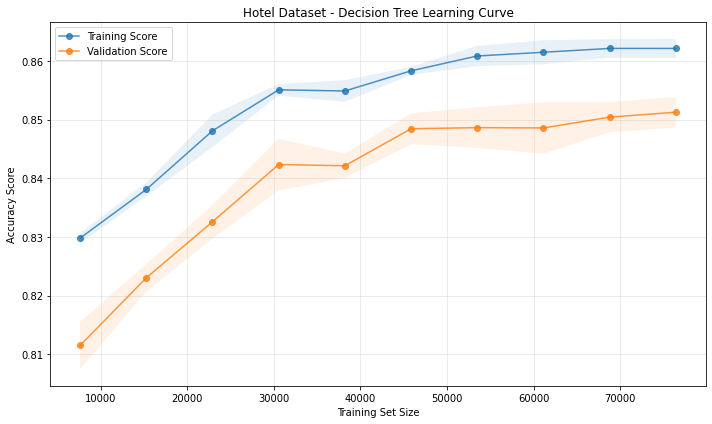

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(dt_hotel_train_sizes, np.mean(dt_hotel_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(dt_hotel_train_sizes, np.mean(dt_hotel_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(dt_hotel_train_sizes, np.mean(dt_hotel_train_scores, axis=1) - np.std(dt_hotel_train_scores, axis=1),
                 np.mean(dt_hotel_train_scores, axis=1) + np.std(dt_hotel_train_scores, axis=1), alpha=0.1)
plt.fill_between(dt_hotel_train_sizes, np.mean(dt_hotel_val_scores, axis=1) - np.std(dt_hotel_val_scores, axis=1),
                 np.mean(dt_hotel_val_scores, axis=1) + np.std(dt_hotel_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Hotel Dataset - Decision Tree Learning Curve') 
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Decision Trees With Accident Data:

#### Organizing by model so I can easily copy + paste each model and make small changes

In [24]:
#gini vs entropy: choosing gini for speed https://datasciencedojo.com/blog/gini-index-and-entropy/
max_samples = min(len(accidents_x_train_pro), 250000)
if len(accidents_x_train_pro) > max_samples:
    accidents_x_train_dt, _, accidents_y_train_dt, _ = train_test_split(
        accidents_x_train_pro, accidents_y_train, 
        train_size=max_samples, stratify=accidents_y_train, random_state=4077010
    )
else:
    accidents_x_train_dt = accidents_x_train_pro
    accidents_y_train_dt = accidents_y_train
    
    
dt_accidents_grid = {
    'max_depth': [6,10,14,18],
    'min_samples_leaf': [100,200],
    'min_samples_split': [100,200,400],
    'ccp_alpha': [0.0, 1e-4, 5e-4, 1e-3]
}

start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024#claude sonnet 4 accessed 9/9/2025

dt_accidents = DecisionTreeClassifier(random_state = 4077010, criterion = 'gini')

dt_accidents_grid_final = GridSearchCV(dt_accidents, dt_accidents_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)
#cv found here https://scikit-learn.org/stable/modules/cross_validation.html
dt_accidents_start = time.time()
dt_accidents_grid_final.fit(accidents_x_train_dt, accidents_y_train_dt)
dt_accidents_total_train_time = time.time() - dt_accidents_start

dt_accidents_best_est = dt_accidents_grid_final.best_estimator_
print('Best Params: ', dt_accidents_grid_final.best_params_)
print('Best CV: ', dt_accidents_grid_final.best_score_ )
print('Time to Train: ', dt_accidents_total_train_time, ' seconds.')

train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"After training RAM: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")#claude sonnet 4 accessed 9/9/2025

Best Params:  {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100}
Best CV:  0.9103119995171319
Time to Train:  326.3017678260803  seconds.
After training RAM: 18127.5 MB (+5.9 MB)


In [25]:
dt_accidents_pred_start = time.time()
dt_accidents_pred = dt_accidents_best_est.predict(accidents_x_test_pro)
dt_accidents_pred_proba = dt_accidents_best_est.predict_proba(accidents_x_test_pro)
dt_accidents_pred_time = time.time() - dt_accidents_pred_start

accidents_dt_accuracy = accuracy_score(accidents_y_test, dt_accidents_pred)
accidents_dt_precision = precision_score(accidents_y_test, dt_accidents_pred, average='weighted')
accidents_dt_recall = recall_score(accidents_y_test, dt_accidents_pred, average='weighted')
accidents_dt_f1 = f1_score(accidents_y_test, dt_accidents_pred, average='weighted')
accidents_dt_roc_auc = roc_auc_score(accidents_y_test, dt_accidents_pred_proba, multi_class='ovr', average='weighted')

print('Accidents DT Accuracy:', accidents_dt_accuracy)
print('Accidents DT ROC-AUC:', accidents_dt_roc_auc)
print('Accidents DT Prediction Time:', dt_accidents_pred_time)

Accidents DT Accuracy: 0.9130311015417819
Accidents DT ROC-AUC: 0.9419097074051365
Accidents DT Prediction Time: 0.6576244831085205


In [26]:
dt_final = dt_accidents_best_est.tree_
print('Final Tree Depth: ', dt_final.max_depth)
print('Number of Leaves: ', dt_final.n_leaves)
print('Nodes: ', dt_final.node_count)

tree_feat = pd.DataFrame({'significance': dt_accidents_best_est.feature_importances_}).sort_values('significance',ascending = False)
print(tree_feat.head(10))

dt_accidents_cm = confusion_matrix(accidents_y_test, dt_accidents_pred)
print('\nConfusion Matrix:\n',dt_accidents_cm)

dt_accidents_train_sizes, dt_accidents_train_scores, dt_accidents_val_scores = learning_curve(
    dt_accidents_best_est, accidents_x_train_dt, accidents_y_train_dt, cv=5, 
    train_sizes=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1], scoring='accuracy'
)

Final Tree Depth:  10
Number of Leaves:  256
Nodes:  511
    significance
36      0.391219
12      0.210777
39      0.131004
35      0.100988
56      0.047783
40      0.016310
55      0.012485
68      0.010699
37      0.010254
31      0.008838

Confusion Matrix:
 [[   4014    8521     906      32]
 [   1079 1182848   41559    5910]
 [    170   50299  209090     309]
 [     33   22734    2874   15301]]


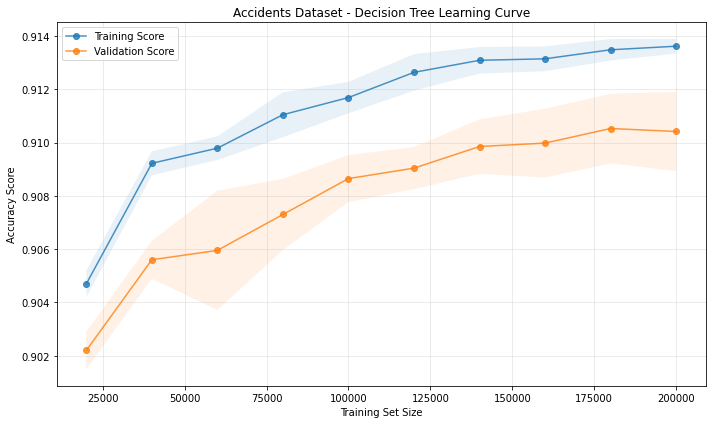

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(dt_accidents_train_sizes, np.mean(dt_accidents_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(dt_accidents_train_sizes, np.mean(dt_accidents_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(dt_accidents_train_sizes, np.mean(dt_accidents_train_scores, axis=1) - np.std(dt_accidents_train_scores, axis=1),
                 np.mean(dt_accidents_train_scores, axis=1) + np.std(dt_accidents_train_scores, axis=1), alpha=0.1)
plt.fill_between(dt_accidents_train_sizes, np.mean(dt_accidents_val_scores, axis=1) - np.std(dt_accidents_val_scores, axis=1),
                 np.mean(dt_accidents_val_scores, axis=1) + np.std(dt_accidents_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Accidents Dataset - Decision Tree Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### KNN With Hotel Data

In [28]:
knn_hotel_grid = {
    'n_neighbors': [3,5,11,21],
    'weights': ['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}

start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024#claude sonnet 4 accessed 9/9/2025
knn_hotel = KNeighborsClassifier(algorithm = 'brute', n_jobs = -1)

knn_hotel_grid_final = GridSearchCV(knn_hotel, knn_hotel_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)

#check this, took 1/2 hour to run - checked it: all better
knn_hotel_start = time.time()
knn_hotel_grid_final.fit(hotel_x_train_pro, hotel_y_train)
knn_hotel_total_train_time = time.time() - knn_hotel_start

knn_hotel_best_est = knn_hotel_grid_final.best_estimator_
print('Best Params: ', knn_hotel_grid_final.best_params_)
print('Best CV: ', knn_hotel_grid_final.best_score_ )
print('Time to Train: ', knn_hotel_total_train_time)

train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"After training RAM: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")#claude sonnet 4 accessed 9/9/2025

Best Params:  {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
Best CV:  0.8535785815191289
Time to Train:  441.3895869255066
After training RAM: 18192.8 MB (+8.8 MB)


In [29]:
knn_hotel_pred_start = time.time()
knn_hotel_pred = knn_hotel_best_est.predict(hotel_x_test_pro)
knn_hotel_pred_proba = knn_hotel_best_est.predict_proba(hotel_x_test_pro)[:, 1]
knn_hotel_pred_time = time.time() - knn_hotel_pred_start

hotel_knn_accuracy = accuracy_score(hotel_y_test, knn_hotel_pred)
hotel_knn_precision = precision_score(hotel_y_test, knn_hotel_pred, average='weighted')
hotel_knn_recall = recall_score(hotel_y_test, knn_hotel_pred, average='weighted')
hotel_knn_f1 = f1_score(hotel_y_test, knn_hotel_pred, average='weighted')
hotel_knn_roc_auc = roc_auc_score(hotel_y_test, knn_hotel_pred_proba)
hotel_knn_pr_auc = average_precision_score(hotel_y_test, knn_hotel_pred_proba)

print('Hotel kNN Accuracy:', hotel_knn_accuracy)
print('Hotel kNN ROC-AUC:', hotel_knn_roc_auc)
print('Hotel kNN PR-AUC:', hotel_knn_pr_auc)
print('Hotel kNN Prediction Time:', knn_hotel_pred_time)

Hotel kNN Accuracy: 0.8594103358740263
Hotel kNN ROC-AUC: 0.9283748318237282
Hotel kNN PR-AUC: 0.9086505628867587
Hotel kNN Prediction Time: 33.5210976600647


In [30]:
knn_hotel_cm = confusion_matrix(hotel_y_test, knn_hotel_pred)
print('Hotel kNN Confusion Matrix:')
print(knn_hotel_cm)

print('Hotel kNN Best k:', knn_hotel_best_est.n_neighbors)
print('Hotel kNN Best weights:', knn_hotel_best_est.weights)
print('Hotel kNN Best metric:', knn_hotel_best_est.metric)
print('Hotel kNN Training samples stored:', knn_hotel_best_est.n_samples_fit_)

knn_hotel_train_sizes, knn_hotel_train_scores, knn_hotel_val_scores = learning_curve(
    knn_hotel_best_est, hotel_x_train_pro, hotel_y_train, cv=2, 
    train_sizes=[.2, .4, .6, .8, 1.0], scoring='accuracy', random_state=4077010
)

Hotel kNN Confusion Matrix:
[[13721  1312]
 [ 2045  6800]]
Hotel kNN Best k: 21
Hotel kNN Best weights: distance
Hotel kNN Best metric: manhattan
Hotel kNN Training samples stored: 95512


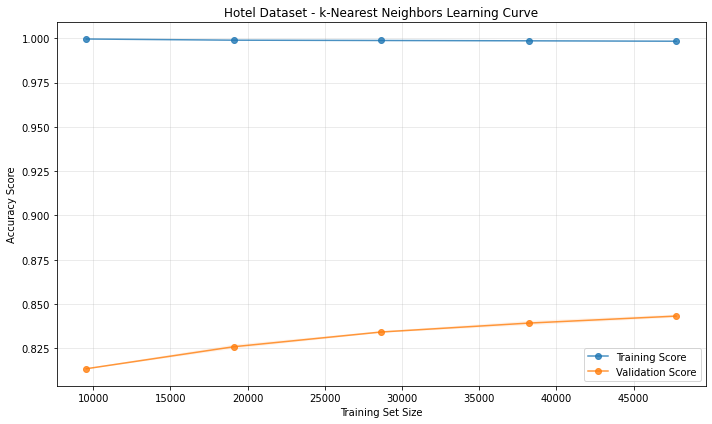

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(knn_hotel_train_sizes, np.mean(knn_hotel_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(knn_hotel_train_sizes, np.mean(knn_hotel_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(knn_hotel_train_sizes, np.mean(knn_hotel_train_scores, axis=1) - np.std(knn_hotel_train_scores, axis=1),
                 np.mean(knn_hotel_train_scores, axis=1) + np.std(knn_hotel_train_scores, axis=1), alpha=0.1)
plt.fill_between(knn_hotel_train_sizes, np.mean(knn_hotel_val_scores, axis=1) - np.std(knn_hotel_val_scores, axis=1),
                 np.mean(knn_hotel_val_scores, axis=1) + np.std(knn_hotel_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Hotel Dataset - k-Nearest Neighbors Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
knn_hotel_cm = confusion_matrix(hotel_y_test, knn_hotel_pred)
print(knn_hotel_cm)

[[13721  1312]
 [ 2045  6800]]


### KNN With Accident Data

In [33]:
knn_train_limit = min(len(accidents_x_train_pro), 125000)
knn_test_limit = min(len(accidents_x_test_pro), 12500)

if len(accidents_x_train_pro) > knn_train_limit:
    accidents_x_train_knn, _, accidents_y_train_knn, _ = train_test_split(
        accidents_x_train_pro, accidents_y_train, 
        train_size=knn_train_limit, stratify=accidents_y_train, random_state=4077010
    )
else:
    accidents_x_train_knn = accidents_x_train_pro
    accidents_y_train_knn = accidents_y_train

if len(accidents_x_test_pro) > knn_test_limit:
    accidents_x_test_knn, _, accidents_y_test_knn, _ = train_test_split(
        accidents_x_test_pro, accidents_y_test, 
        train_size=knn_test_limit, stratify=accidents_y_test, random_state=4077010
    )
else:
    accidents_x_test_knn = accidents_x_test_pro
    accidents_y_test_knn = accidents_y_test
    
    
knn_accidents_grid = {
    'n_neighbors': [5,11,21],
    'weights': ['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}
start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024#claude sonnet 4 accessed 9/9/2025

knn_accidents = KNeighborsClassifier(algorithm = 'brute', n_jobs = -1)

knn_accidents_grid_final = GridSearchCV(knn_accidents, knn_accidents_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)

knn_accidents_start = time.time()
knn_accidents_grid_final.fit(accidents_x_train_knn, accidents_y_train_knn)
knn_accidents_total_train_time = time.time() - knn_accidents_start

knn_accidents_best_est = knn_accidents_grid_final.best_estimator_
print('Best Params: ', knn_accidents_grid_final.best_params_)
print('Best CV: ', knn_accidents_grid_final.best_score_)
print('Time to Train: ', knn_accidents_total_train_time)

train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"After training RAM: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")#claude sonnet 4 accessed 9/9/2025

Best Params:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best CV:  0.8943200063865241
Time to Train:  581.4272198677063
After training RAM: 18203.4 MB (+8.2 MB)


In [34]:
knn_accidents_pred_start = time.time()
knn_accidents_final = knn_accidents_grid_final.best_estimator_
knn_accidents_pred = knn_accidents_final.predict(accidents_x_test_knn)
knn_accidents_pred_time = time.time() - knn_accidents_pred_start
knn_accidents_accuracy = accuracy_score(accidents_y_test_knn, knn_accidents_pred)

print('Time to Predict: ', knn_accidents_pred_time)
print('Accuracy: ',knn_accidents_accuracy)

Time to Predict:  11.416903972625732
Accuracy:  0.89568


In [35]:
knn_accidents_cm = confusion_matrix(accidents_y_test_knn, knn_accidents_pred)
print('\nConfusion Matrix:\n', knn_accidents_cm)

knn_accidents_train_sizes, knn_accidents_train_scores, knn_accidents_val_scores = learning_curve(
    knn_accidents_best_est, accidents_x_train_knn, accidents_y_train_knn, cv=3, 
    train_sizes=[.2, .4, .6, .8, 1.0], scoring='accuracy'
)

print('Best k:', knn_accidents_best_est.n_neighbors)
print('Best weights:', knn_accidents_best_est.weights)
print('Best metric:', knn_accidents_best_est.metric)
print('Training samples stored:', knn_accidents_best_est.n_samples_fit_)


Confusion Matrix:
 [[  14   91    4    0]
 [   0 9663  289    6]
 [   0  628 1472    2]
 [   0  260   24   47]]
Best k: 11
Best weights: distance
Best metric: manhattan
Training samples stored: 125000


In [36]:
accidents_knn_accuracy = accuracy_score(accidents_y_test_knn, knn_accidents_pred)
accidents_knn_precision = precision_score(accidents_y_test_knn, knn_accidents_pred, average='weighted')
accidents_knn_recall = recall_score(accidents_y_test_knn, knn_accidents_pred, average='weighted')
accidents_knn_f1 = f1_score(accidents_y_test_knn, knn_accidents_pred, average='weighted')

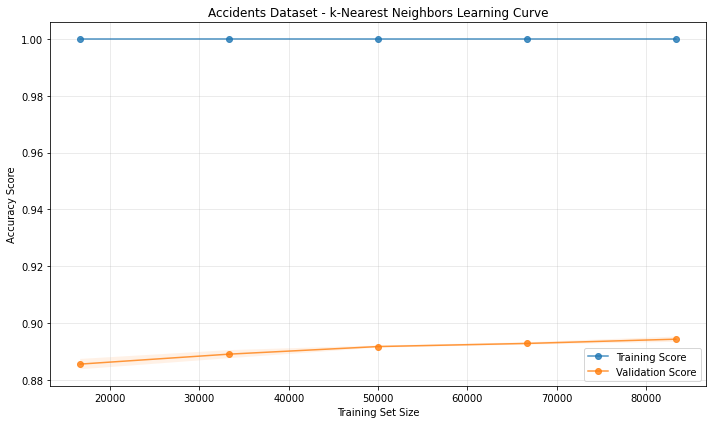

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(knn_accidents_train_sizes, np.mean(knn_accidents_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(knn_accidents_train_sizes, np.mean(knn_accidents_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(knn_accidents_train_sizes, np.mean(knn_accidents_train_scores, axis=1) - np.std(knn_accidents_train_scores, axis=1),
                 np.mean(knn_accidents_train_scores, axis=1) + np.std(knn_accidents_train_scores, axis=1), alpha=0.1)
plt.fill_between(knn_accidents_train_sizes, np.mean(knn_accidents_val_scores, axis=1) - np.std(knn_accidents_val_scores, axis=1),
                 np.mean(knn_accidents_val_scores, axis=1) + np.std(knn_accidents_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Accidents Dataset - k-Nearest Neighbors Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### SVM With Hotel Data

In [38]:
#Linear
from sklearn.svm import LinearSVC

linear_hotel_param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024#claude sonnet 4 accessed 9/9/2025

linear_hotel_svm = LinearSVC(random_state=4077010, max_iter=10000)
linear_hotel_grid = GridSearchCV(linear_hotel_svm, linear_hotel_param_grid, cv=3, scoring='accuracy', n_jobs=-1)

linear_hotel_start_time = time.time()
linear_hotel_grid.fit(hotel_x_train_pro, hotel_y_train)
linear_hotel_tuning_time = time.time() - linear_hotel_start_time

train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"After training linear SVM RAM: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")#claude sonnet 4 accessed 9/9/2025
print('Time to Train: ', linear_hotel_tuning_time)

linear_hotel_best = linear_hotel_grid.best_estimator_
print('Best linear SVM parameters: ', linear_hotel_grid.best_params_)
print('Best linear SVM CV score: ', linear_hotel_grid.best_score_)


After training linear SVM RAM: 13043.0 MB (+-0.8 MB)
Time to Train:  38.71409296989441
Best linear SVM parameters:  {'C': 1, 'class_weight': None}
Best linear SVM CV score:  0.814860965319669


In [46]:
hotel_rbf_sample_size = min(len(hotel_x_train_pro), 12500)
if len(hotel_x_train_pro) > hotel_rbf_sample_size:
    hotel_x_train_rbf, _, hotel_y_train_rbf, _ = train_test_split(
        hotel_x_train_pro, hotel_y_train, 
        train_size=hotel_rbf_sample_size, stratify=hotel_y_train, random_state=4077010
    )
else:
    hotel_x_train_rbf = hotel_x_train_pro
    hotel_y_train_rbf = hotel_y_train
rbf_hotel_param_grid = {
    'C': [2], 
    'class_weight': ['balanced']
}
rbf_hotel_svm = SVC(kernel='rbf', random_state=4077010, probability=True)
rbf_hotel_grid = GridSearchCV(rbf_hotel_svm, rbf_hotel_param_grid, cv=2, scoring='accuracy', n_jobs=-1)
start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
rbf_hotel_start_time = time.time()
rbf_hotel_grid.fit(hotel_x_train_rbf, hotel_y_train_rbf)
rbf_hotel_train_time = time.time() - rbf_hotel_start_time
train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"Hotel RBF SVM RAM usage: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")
print('Hotel RBF SVM Training Time:', rbf_hotel_train_time)
rbf_hotel_best = rbf_hotel_grid.best_estimator_
print('Hotel RBF SVM Best Params:', rbf_hotel_grid.best_params_)
print('Hotel RBF SVM Best CV Score:', rbf_hotel_grid.best_score_)

Hotel RBF SVM RAM usage: 383.7 MB (+-90.9 MB)
Hotel RBF SVM Training Time: 48.54527163505554
Hotel RBF SVM Best Params: {'C': 2, 'class_weight': 'balanced'}
Hotel RBF SVM Best CV Score: 0.82256


In [47]:
linear_hotel_pred_start = time.time()
hotel_linear_pred = linear_hotel_best.predict(hotel_x_test_pro)
linear_hotel_pred_time = time.time() - linear_hotel_pred_start

rbf_hotel_pred_start = time.time()
hotel_rbf_pred = rbf_hotel_best.predict(hotel_x_test_pro)
hotel_rbf_pred_proba = rbf_hotel_best.predict_proba(hotel_x_test_pro)[:, 1]
rbf_hotel_pred_time = time.time() - rbf_hotel_pred_start

print('Hotel Linear SVM Prediction Time:', linear_hotel_pred_time)
print('Hotel RBF SVM Prediction Time:', rbf_hotel_pred_time)

Hotel Linear SVM Prediction Time: 0.005945444107055664
Hotel RBF SVM Prediction Time: 26.705576181411743


In [48]:
hotel_linear_train_sizes, hotel_linear_train_scores, hotel_linear_val_scores = learning_curve(
    linear_hotel_best, hotel_x_train_pro, hotel_y_train, cv=2, train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0],
    scoring='accuracy', random_state=4077010, n_jobs=-1
)

"""hotel_rbf_train_sizes, hotel_rbf_train_scores, hotel_rbf_val_scores = learning_curve(
    rbf_hotel_best, hotel_x_train_pro, hotel_y_train, cv=2, train_sizes=[0.4, 0.7, 1.0],
    scoring='accuracy', random_state=4077010, n_jobs=-1
)"""

hotel_linear_accuracy = accuracy_score(hotel_y_test, hotel_linear_pred)
hotel_linear_precision = precision_score(hotel_y_test, hotel_linear_pred, average='weighted')
hotel_linear_recall = recall_score(hotel_y_test, hotel_linear_pred, average='weighted')
hotel_linear_f1 = f1_score(hotel_y_test, hotel_linear_pred, average='weighted')

hotel_rbf_accuracy = accuracy_score(hotel_y_test, hotel_rbf_pred)
hotel_rbf_precision = precision_score(hotel_y_test, hotel_rbf_pred, average='weighted')
hotel_rbf_recall = recall_score(hotel_y_test, hotel_rbf_pred, average='weighted')
hotel_rbf_f1 = f1_score(hotel_y_test, hotel_rbf_pred, average='weighted')
hotel_rbf_roc_auc = roc_auc_score(hotel_y_test, hotel_rbf_pred_proba)

print('Hotel Linear SVM Accuracy:', hotel_linear_accuracy)
print('Hotel Linear SVM Precision:', hotel_linear_precision)
print('Hotel Linear SVM Recall:', hotel_linear_recall)
print('Hotel Linear SVM F1:', hotel_linear_f1)
print('Hotel RBF SVM Accuracy:', hotel_rbf_accuracy)
print('Hotel RBF SVM Precision:', hotel_rbf_precision)
print('Hotel RBF SVM Recall:', hotel_rbf_recall)
print('Hotel RBF SVM F1:', hotel_rbf_f1)
print('Hotel RBF SVM ROC-AUC:', hotel_rbf_roc_auc)

Hotel Linear SVM Accuracy: 0.8144735740011726
Hotel Linear SVM Precision: 0.8143620611065747
Hotel Linear SVM Recall: 0.8144735740011726
Hotel Linear SVM F1: 0.8091978349699249
Hotel RBF SVM Accuracy: 0.8375073289220203
Hotel RBF SVM Precision: 0.8400652792165227
Hotel RBF SVM Recall: 0.8375073289220203
Hotel RBF SVM F1: 0.838388240916268
Hotel RBF SVM ROC-AUC: 0.9119257475272884


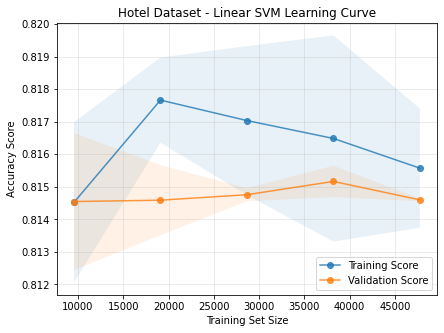

In [50]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hotel_linear_train_sizes, np.mean(hotel_linear_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(hotel_linear_train_sizes, np.mean(hotel_linear_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(hotel_linear_train_sizes, np.mean(hotel_linear_train_scores, axis=1) - np.std(hotel_linear_train_scores, axis=1),
                 np.mean(hotel_linear_train_scores, axis=1) + np.std(hotel_linear_train_scores, axis=1), alpha=0.1)
plt.fill_between(hotel_linear_train_sizes, np.mean(hotel_linear_val_scores, axis=1) - np.std(hotel_linear_val_scores, axis=1),
                 np.mean(hotel_linear_val_scores, axis=1) + np.std(hotel_linear_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Hotel Dataset - Linear SVM Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)


In [ ]:

plt.subplot(1, 2, 2)
plt.plot(hotel_rbf_train_sizes, np.mean(hotel_rbf_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(hotel_rbf_train_sizes, np.mean(hotel_rbf_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(hotel_rbf_train_sizes, np.mean(hotel_rbf_train_scores, axis=1) - np.std(hotel_rbf_train_scores, axis=1),
                 np.mean(hotel_rbf_train_scores, axis=1) + np.std(hotel_rbf_train_scores, axis=1), alpha=0.1)
plt.fill_between(hotel_rbf_train_sizes, np.mean(hotel_rbf_val_scores, axis=1) - np.std(hotel_rbf_val_scores, axis=1),
                 np.mean(hotel_rbf_val_scores, axis=1) + np.std(hotel_rbf_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Hotel Dataset - RBF SVM Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [51]:
linear_hotel_cm = confusion_matrix(hotel_y_test, hotel_linear_pred)
print(linear_hotel_cm)

rbf_hotel_cm = confusion_matrix(hotel_y_test, hotel_rbf_pred)
print(rbf_hotel_cm)

[[13719  1314]
 [ 3116  5729]]
[[12836  2197]
 [ 1683  7162]]


### SVM With Accident Data

In [55]:
linear_sample_size = min(len(accidents_x_train_pro), 125000) #runtime: sampling more
accidents_x_train_linear, _, accidents_y_train_linear, _ = train_test_split(
    accidents_x_train_pro, accidents_y_train, 
    train_size=linear_sample_size, stratify=accidents_y_train, random_state=4077010
)

linear_accidents_param_grid = {
    'C': [10], 
    'class_weight': ['balanced']
}
linear_accidents_svm = LinearSVC(random_state=4077010, max_iter=5000)
linear_accidents_grid = GridSearchCV(linear_accidents_svm, linear_accidents_param_grid, cv=2, scoring='accuracy', n_jobs=-1)

start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024#claude sonnet 4 accessed 9/9/2025

linear_accidents_start_time = time.time()
linear_accidents_grid.fit(accidents_x_train_linear, accidents_y_train_linear)
linear_accidents_tuning_time = time.time() - linear_accidents_start_time

train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"Accidents Linear SVM RAM usage: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")#claude sonnet 4 accessed 9/9/2025
print('Accidents Linear SVM Training Time:', linear_accidents_tuning_time)

linear_accidents_best = linear_accidents_grid.best_estimator_
print('Accidents Linear SVM Best Params:', linear_accidents_grid.best_params_)
print('Accidents Linear SVM Best CV Score:', linear_accidents_grid.best_score_)


Accidents Linear SVM RAM usage: 7768.5 MB (+0.3 MB)
Accidents Linear SVM Training Time: 120.5289409160614
Accidents Linear SVM Best Params: {'C': 10, 'class_weight': 'balanced'}
Accidents Linear SVM Best CV Score: 0.891


In [56]:
rbf_train_limit = min(len(accidents_x_train_pro), 12500)
if len(accidents_x_train_pro) > rbf_train_limit:
    accidents_x_train_rbf, _, accidents_y_train_rbf, _ = train_test_split(
        accidents_x_train_pro, accidents_y_train, 
        train_size=rbf_train_limit, stratify=accidents_y_train, random_state=4077010
    )
else:
    accidents_x_train_rbf = accidents_x_train_pro
    accidents_y_train_rbf = accidents_y_train

rbf_accidents_param_grid = {
    'C': [2], 
    'class_weight': ['balanced']
}

rbf_accidents_svm = SVC(kernel='rbf', random_state=4077010, probability=True)
rbf_accidents_grid = GridSearchCV(rbf_accidents_svm, rbf_accidents_param_grid, cv=2, scoring='accuracy', n_jobs=-1)

start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
rbf_accidents_start_time = time.time()
rbf_accidents_grid.fit(accidents_x_train_rbf, accidents_y_train_rbf)
rbf_accidents_train_time = time.time() - rbf_accidents_start_time

train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"Accidents RBF SVM RAM usage: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")
print('Accidents RBF SVM Training Time:', rbf_accidents_train_time)

rbf_accidents_best = rbf_accidents_grid.best_estimator_
print('Accidents RBF SVM Best Params:', rbf_accidents_grid.best_params_)
print('Accidents RBF SVM Best CV Score:', rbf_accidents_grid.best_score_)

Accidents RBF SVM RAM usage: 7778.9 MB (+8.7 MB)
Accidents RBF SVM Training Time: 85.70182585716248
Accidents RBF SVM Best Params: {'C': 2, 'class_weight': 'balanced'}
Accidents RBF SVM Best CV Score: 0.78808


In [57]:
test_sample_size = min(len(accidents_x_test_pro), 25000)
if len(accidents_x_test_pro) > test_sample_size:
    accidents_x_test_sample, _, accidents_y_test_sample, _ = train_test_split(
        accidents_x_test_pro, accidents_y_test, 
        train_size=test_sample_size, stratify=accidents_y_test, random_state=4077010
    )
else:
    accidents_x_test_sample = accidents_x_test_pro
    accidents_y_test_sample = accidents_y_test

linear_accidents_pred_start = time.time()
accidents_linear_pred = linear_accidents_best.predict(accidents_x_test_sample)
linear_accidents_pred_time = time.time() - linear_accidents_pred_start

rbf_accidents_pred_start = time.time()
accidents_rbf_pred = rbf_accidents_best.predict(accidents_x_test_sample) 
accidents_rbf_pred_proba = rbf_accidents_best.predict_proba(accidents_x_test_sample)
rbf_accidents_pred_time = time.time() - rbf_accidents_pred_start

print('Accidents Linear SVM Prediction Time:', linear_accidents_pred_time)
print('Accidents RBF SVM Prediction Time:', rbf_accidents_pred_time)

Using 25,000 test samples for predictions
Accidents Linear SVM Prediction Time: 0.015871763229370117
Accidents RBF SVM Prediction Time: 39.094281911849976


In [58]:
accidents_linear_train_sizes, accidents_linear_train_scores, accidents_linear_val_scores = learning_curve(
    linear_accidents_best, accidents_x_train_linear, accidents_y_train_linear, cv=2, train_sizes=[0.4, 0.7, 1.0],
    scoring='accuracy', random_state=4077010, n_jobs=-1
)

accidents_rbf_train_sizes, accidents_rbf_train_scores, accidents_rbf_val_scores = learning_curve(
    rbf_accidents_best, accidents_x_train_rbf, accidents_y_train_rbf, cv=2, train_sizes=[0.5, 1.0],
    scoring='accuracy', random_state=4077010, n_jobs=-1
)

rbf_accidents_pred_start = time.time()
accidents_rbf_pred = rbf_accidents_best.predict(accidents_x_test_sample)
rbf_accidents_pred_time = time.time() - rbf_accidents_pred_start

accidents_linear_accuracy = accuracy_score(accidents_y_test_sample, accidents_linear_pred)
accidents_linear_precision = precision_score(accidents_y_test_sample, accidents_linear_pred, average='weighted')
accidents_linear_recall = recall_score(accidents_y_test_sample, accidents_linear_pred, average='weighted')
accidents_linear_f1 = f1_score(accidents_y_test_sample, accidents_linear_pred, average='weighted')

accidents_rbf_accuracy = accuracy_score(accidents_y_test_sample, accidents_rbf_pred)
accidents_rbf_precision = precision_score(accidents_y_test_sample, accidents_rbf_pred, average='weighted')
accidents_rbf_recall = recall_score(accidents_y_test_sample, accidents_rbf_pred, average='weighted')
accidents_rbf_f1 = f1_score(accidents_y_test_sample, accidents_rbf_pred, average='weighted')
accidents_rbf_roc_auc = roc_auc_score(accidents_y_test_sample, accidents_rbf_pred_proba, multi_class='ovr', average='weighted')

print('Accidents Linear SVM Accuracy:', accidents_linear_accuracy)
print('Accidents Linear SVM Precision:', accidents_linear_precision)
print('Accidents Linear SVM Recall:', accidents_linear_recall)
print('Accidents Linear SVM F1:', accidents_linear_f1)
print('Accidents RBF SVM Accuracy:', accidents_rbf_accuracy)
print('Accidents RBF SVM Precision:', accidents_rbf_precision)
print('Accidents RBF SVM Recall:', accidents_rbf_recall)
print('Accidents RBF SVM F1:', accidents_rbf_f1)
print('Accidents RBF SVM ROC-AUC:', accidents_rbf_roc_auc)

Accidents Linear SVM Accuracy: 0.89288
Accidents Linear SVM Precision: 0.8966817427664383
Accidents Linear SVM Recall: 0.89288
Accidents Linear SVM F1: 0.8944963324574681
Accidents RBF SVM Accuracy: 0.77492
Accidents RBF SVM Precision: 0.8886810818710515
Accidents RBF SVM Recall: 0.77492
Accidents RBF SVM F1: 0.8161933671510198
Accidents RBF SVM ROC-AUC: 0.9293326513540783


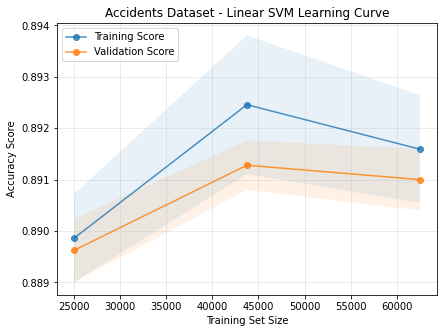

In [61]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(accidents_linear_train_sizes, np.mean(accidents_linear_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(accidents_linear_train_sizes, np.mean(accidents_linear_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(accidents_linear_train_sizes, np.mean(accidents_linear_train_scores, axis=1) - np.std(accidents_linear_train_scores, axis=1),
                 np.mean(accidents_linear_train_scores, axis=1) + np.std(accidents_linear_train_scores, axis=1), alpha=0.1)
plt.fill_between(accidents_linear_train_sizes, np.mean(accidents_linear_val_scores, axis=1) - np.std(accidents_linear_val_scores, axis=1),
                 np.mean(accidents_linear_val_scores, axis=1) + np.std(accidents_linear_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Accidents Dataset - Linear SVM Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)


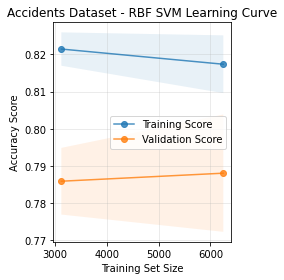

In [59]:
plt.subplot(1, 2, 2)
plt.plot(accidents_rbf_train_sizes, np.mean(accidents_rbf_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(accidents_rbf_train_sizes, np.mean(accidents_rbf_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(accidents_rbf_train_sizes, np.mean(accidents_rbf_train_scores, axis=1) - np.std(accidents_rbf_train_scores, axis=1),
                 np.mean(accidents_rbf_train_scores, axis=1) + np.std(accidents_rbf_train_scores, axis=1), alpha=0.1)
plt.fill_between(accidents_rbf_train_sizes, np.mean(accidents_rbf_val_scores, axis=1) - np.std(accidents_rbf_val_scores, axis=1),
                 np.mean(accidents_rbf_val_scores, axis=1) + np.std(accidents_rbf_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Accidents Dataset - RBF SVM Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
linear_accidents_cm = confusion_matrix(accidents_y_test_sample, accidents_linear_pred)
print(linear_accidents_cm)

rbf_accidents_cm = confusion_matrix(accidents_y_test_sample, accidents_rbf_pred)
print(rbf_accidents_cm)

[[  101   107     8     2]
 [   97 18444  1018   358]
 [   28   695  3447    33]
 [    4   275    53   330]]
[[  129    58    20    11]
 [ 1354 15215  1492  1856]
 [   74   375  3606   148]
 [   15   176    48   423]]


## NN on Hotel Data

In [62]:
shallow_hotel_model = MLPClassifier(
    hidden_layer_sizes=(200, 200),
    solver='sgd',
    learning_rate_init=0.01,
    batch_size=512,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=3,
    random_state=4077010,
    alpha=1e-4
)

deep_hotel_model = MLPClassifier(
    hidden_layer_sizes=(150, 100, 75, 50),
    solver='sgd',
    learning_rate_init=0.01,
    batch_size=512,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=3,
    random_state=4077010,
    alpha=1e-4
)

shallow_hotel_cv = cross_val_score(shallow_hotel_model, hotel_x_train_pro, hotel_y_train, cv=3, scoring='accuracy')
shallow_hotel_score = shallow_hotel_cv.mean()
print('Shallow CV score:', shallow_hotel_score)

deep_hotel_cv = cross_val_score(deep_hotel_model, hotel_x_train_pro, hotel_y_train, cv=3, scoring='accuracy')
deep_hotel_score = deep_hotel_cv.mean()
print('Deep CV score:', deep_hotel_score)

if shallow_hotel_score > deep_hotel_score:
    best_hotel_model = shallow_hotel_model
else:
    best_hotel_model = deep_hotel_model

Shallow CV score: 0.8535053295234167
Deep CV score: 0.8571802406918222


In [63]:
start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024#claude sonnet 4 accessed 9/9/2025
nn_hotel_fit_start = time.time()
best_hotel_model.fit(hotel_x_train_pro, hotel_y_train)
nn_hotel_fit_time = time.time() - nn_hotel_fit_start

train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"Hotel NN RAM usage: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")#claude sonnet 4 accessed 9/9/2025

nn_hotel_pred_start = time.time()
hotel_nn_pred = best_hotel_model.predict(hotel_x_test_pro)
hotel_nn_pred_proba = best_hotel_model.predict_proba(hotel_x_test_pro)[:, 1]
nn_hotel_pred_time = time.time() - nn_hotel_pred_start

hotel_nn_accuracy = accuracy_score(hotel_y_test, hotel_nn_pred)
hotel_nn_precision = precision_score(hotel_y_test, hotel_nn_pred, average='weighted')
hotel_nn_recall = recall_score(hotel_y_test, hotel_nn_pred, average='weighted')
hotel_nn_f1 = f1_score(hotel_y_test, hotel_nn_pred, average='weighted')
hotel_nn_roc_auc = roc_auc_score(hotel_y_test, hotel_nn_pred_proba)
hotel_nn_pr_auc = average_precision_score(hotel_y_test, hotel_nn_pred_proba)

print('Hotel NN Accuracy:', hotel_nn_accuracy)
print('Hotel NN ROC-AUC:', hotel_nn_roc_auc)
print('Hotel NN PR-AUC:', hotel_nn_pr_auc)
print('Hotel NN Fit Time:', nn_hotel_fit_time)
print('Hotel NN Predict Time:', nn_hotel_pred_time)
print('Hotel NN Final Iterations:', best_hotel_model.n_iter_)

Hotel NN RAM usage: 8455.5 MB (+18.6 MB)
Hotel NN Accuracy: 0.8617555909205126
Hotel NN ROC-AUC: 0.9367422497714375
Hotel NN PR-AUC: 0.9114612761709164
Hotel NN Fit Time: 14.784907102584839
Hotel NN Predict Time: 0.19244813919067383
Hotel NN Final Iterations: 18


In [64]:
hotel_nn_train_sizes, hotel_nn_train_scores, hotel_nn_val_scores = learning_curve(
    best_hotel_model, hotel_x_train_pro, hotel_y_train, cv=2, train_sizes=[0.4, 0.7, 1.0],
    scoring='accuracy', random_state=4077010, n_jobs=-1
)

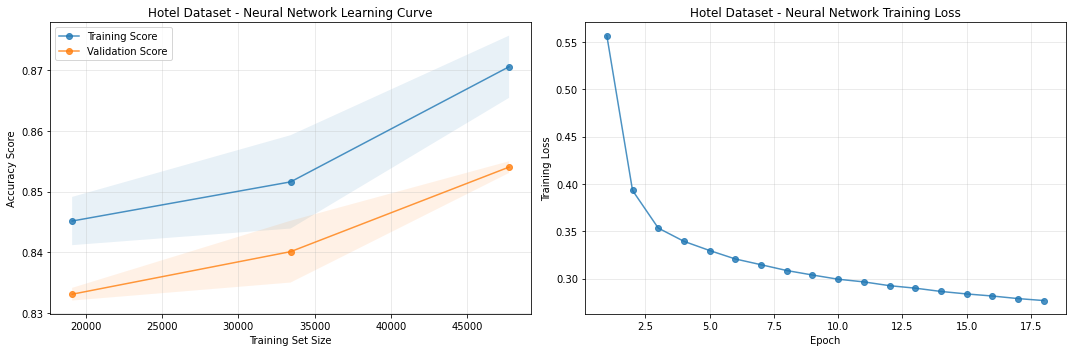

In [65]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hotel_nn_train_sizes, np.mean(hotel_nn_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(hotel_nn_train_sizes, np.mean(hotel_nn_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(hotel_nn_train_sizes, np.mean(hotel_nn_train_scores, axis=1) - np.std(hotel_nn_train_scores, axis=1),
                 np.mean(hotel_nn_train_scores, axis=1) + np.std(hotel_nn_train_scores, axis=1), alpha=0.1)
plt.fill_between(hotel_nn_train_sizes, np.mean(hotel_nn_val_scores, axis=1) - np.std(hotel_nn_val_scores, axis=1),
                 np.mean(hotel_nn_val_scores, axis=1) + np.std(hotel_nn_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Hotel Dataset - Neural Network Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, best_hotel_model.n_iter_ + 1), best_hotel_model.loss_curve_, 'o-', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Hotel Dataset - Neural Network Training Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

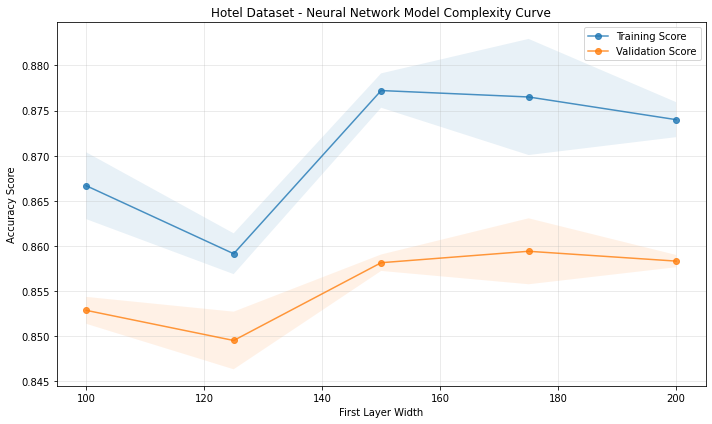

In [66]:
if best_hotel_model.hidden_layer_sizes == (200, 200):
    widths = [100, 150, 200, 250, 300]
    param_range = [(w, w) for w in widths]
    x_values = widths
    x_label = 'Hidden Layer Width'
else:
    widths = [100, 125, 150, 175, 200]
    param_range = [(w, int(w*0.67), int(w*0.5), int(w*0.33)) for w in widths]
    x_values = widths
    x_label = 'First Layer Width'

nn_train_scores, nn_val_scores = validation_curve(
    MLPClassifier(
        solver='sgd',
        learning_rate_init=0.01,
        batch_size=512,
        max_iter=50,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=3,
        random_state=4077010,
        alpha=1e-4
    ),
    hotel_x_train_pro, hotel_y_train,
    param_name='hidden_layer_sizes',
    param_range=param_range,
    cv=3, scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(x_values, np.mean(nn_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(x_values, np.mean(nn_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(x_values, np.mean(nn_train_scores, axis=1) - np.std(nn_train_scores, axis=1),
                 np.mean(nn_train_scores, axis=1) + np.std(nn_train_scores, axis=1), alpha=0.1)
plt.fill_between(x_values, np.mean(nn_val_scores, axis=1) - np.std(nn_val_scores, axis=1),
                 np.mean(nn_val_scores, axis=1) + np.std(nn_val_scores, axis=1), alpha=0.1)
plt.xlabel(x_label)
plt.ylabel('Accuracy Score')
plt.title('Hotel Dataset - Neural Network Model Complexity Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
nn_hotel_cm = confusion_matrix(hotel_y_test, hotel_nn_pred)
print(nn_hotel_cm)

[[13493  1540]
 [ 1761  7084]]


## NN on Accident Data

In [68]:
nn_sample_size = min(len(accidents_x_train_pro), 1000000)
if len(accidents_x_train_pro) > nn_sample_size:
    accidents_x_train_nn, _, accidents_y_train_nn, _ = train_test_split(
        accidents_x_train_pro, accidents_y_train, 
        train_size=nn_sample_size, stratify=accidents_y_train, random_state=4077010
    )
else:
    accidents_x_train_nn = accidents_x_train_pro
    accidents_y_train_nn = accidents_y_train

shallow_accidents_model = MLPClassifier(
    hidden_layer_sizes=(512, 512),
    solver='sgd',
    learning_rate_init=0.01,
    batch_size=512,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=3,
    random_state=4077010,
    alpha=1e-4
)

shallow_accidents_cv = cross_val_score(shallow_accidents_model, accidents_x_train_nn, accidents_y_train_nn, cv=2, scoring='accuracy')
shallow_accidents_score = shallow_accidents_cv.mean()
print('Accidents Shallow CV score:', shallow_accidents_score)

deep_accidents_model = MLPClassifier(
    hidden_layer_sizes=(150, 100, 75, 50),
    solver='sgd',
    learning_rate_init=0.01,
    batch_size=512,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=3,
    random_state=4077010,
    alpha=1e-4
)

deep_accidents_cv = cross_val_score(deep_accidents_model, accidents_x_train_nn, accidents_y_train_nn, cv=2, scoring='accuracy')
deep_accidents_score = deep_accidents_cv.mean()
print('Accidents Deep CV score:', deep_accidents_score)

if shallow_accidents_score > deep_accidents_score:
    best_accidents_model = shallow_accidents_model
else:
    best_accidents_model = deep_accidents_model

Accidents Shallow CV score: 0.912338
Accidents Deep CV score: 0.913478


In [69]:
start_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024#claude sonnet 4 accessed 9/9/2025
nn_accidents_fit_start = time.time()
best_accidents_model.fit(accidents_x_train_nn, accidents_y_train_nn)  
nn_accidents_fit_time = time.time() - nn_accidents_fit_start
train_ram = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
print(f"Accidents NN RAM usage: {train_ram:.1f} MB (+{train_ram - start_ram:.1f} MB)")#claude sonnet 4 accessed 9/9/2025

nn_accidents_pred_start = time.time()
accidents_nn_pred = best_accidents_model.predict(accidents_x_test_sample) 
accidents_nn_pred_proba = best_accidents_model.predict_proba(accidents_x_test_sample) 
nn_accidents_pred_time = time.time() - nn_accidents_pred_start

accidents_nn_accuracy = accuracy_score(accidents_y_test_sample, accidents_nn_pred) 
accidents_nn_precision = precision_score(accidents_y_test_sample, accidents_nn_pred, average='weighted')
accidents_nn_recall = recall_score(accidents_y_test_sample, accidents_nn_pred, average='weighted')
accidents_nn_f1 = f1_score(accidents_y_test_sample, accidents_nn_pred, average='weighted')
accidents_nn_roc_auc = roc_auc_score(accidents_y_test_sample, accidents_nn_pred_proba, multi_class='ovr', average='weighted')

print('Accidents NN Accuracy:', accidents_nn_accuracy)
print('Accidents NN ROC-AUC:', accidents_nn_roc_auc)
print('Accidents NN Fit Time:', nn_accidents_fit_time)
print('Accidents NN Predict Time:', nn_accidents_pred_time)
print('Accidents NN Final Iterations:', best_accidents_model.n_iter_)

Accidents NN RAM usage: 5422.3 MB (+-119.0 MB)
Accidents NN Accuracy: 0.91684
Accidents NN ROC-AUC: 0.9580019391752734
Accidents NN Fit Time: 239.4771282672882
Accidents NN Predict Time: 0.2589108943939209
Accidents NN Final Iterations: 27


In [70]:
accidents_nn_train_sizes, accidents_nn_train_scores, accidents_nn_val_scores = learning_curve(
    best_accidents_model, accidents_x_train_nn, accidents_y_train_nn, cv=2, train_sizes=[0.5, 1.0],
    scoring='accuracy', random_state=4077010, n_jobs=-1
)

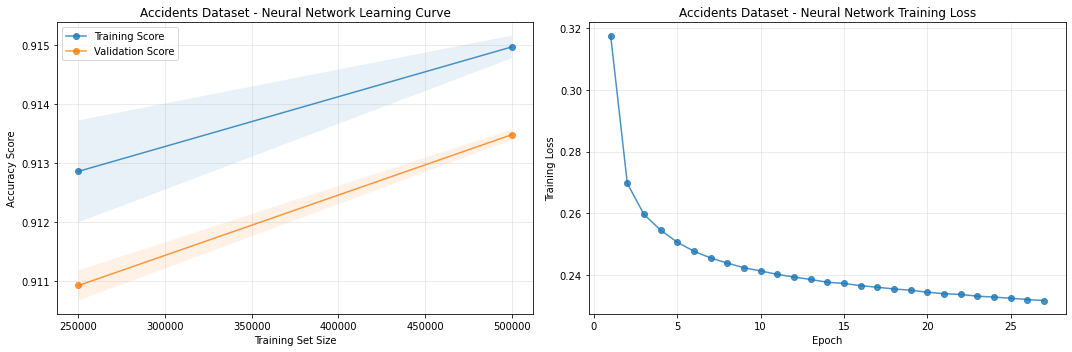

In [71]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(accidents_nn_train_sizes, np.mean(accidents_nn_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(accidents_nn_train_sizes, np.mean(accidents_nn_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(accidents_nn_train_sizes, np.mean(accidents_nn_train_scores, axis=1) - np.std(accidents_nn_train_scores, axis=1),
                 np.mean(accidents_nn_train_scores, axis=1) + np.std(accidents_nn_train_scores, axis=1), alpha=0.1)
plt.fill_between(accidents_nn_train_sizes, np.mean(accidents_nn_val_scores, axis=1) - np.std(accidents_nn_val_scores, axis=1),
                 np.mean(accidents_nn_val_scores, axis=1) + np.std(accidents_nn_val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Accidents Dataset - Neural Network Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, best_accidents_model.n_iter_ + 1), best_accidents_model.loss_curve_, 'o-', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Accidents Dataset - Neural Network Training Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

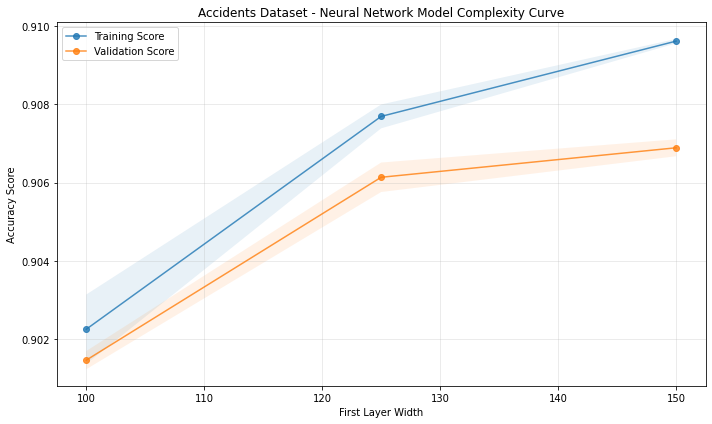

In [80]:
sample_size = min(250000, len(accidents_x_train_pro))
accidents_x_sample = accidents_x_train_pro[:sample_size]
accidents_y_sample = accidents_y_train[:sample_size]

if best_accidents_model.hidden_layer_sizes == (200, 200):
    widths = [100, 150, 200]
    param_range = [(w, w) for w in widths]
    x_values = widths
    x_label = 'Hidden Layer Width'
else:
    widths = [100, 125, 150]
    param_range = [(w, int(w*0.67), int(w*0.5), int(w*0.33)) for w in widths]
    x_values = widths
    x_label = 'First Layer Width'

nn_train_scores, nn_val_scores = validation_curve(
    MLPClassifier(
        solver='sgd',
        learning_rate_init=0.01,
        batch_size=512,
        max_iter=50,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=2,
        random_state=4077010,
        alpha=1e-4
    ),
    accidents_x_sample, accidents_y_sample, 
    param_name='hidden_layer_sizes',
    param_range=param_range,
    cv=2, scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(x_values, np.mean(nn_train_scores, axis=1), 'o-', label='Training Score', alpha=0.8)
plt.plot(x_values, np.mean(nn_val_scores, axis=1), 'o-', label='Validation Score', alpha=0.8)
plt.fill_between(x_values, np.mean(nn_train_scores, axis=1) - np.std(nn_train_scores, axis=1),
                 np.mean(nn_train_scores, axis=1) + np.std(nn_train_scores, axis=1), alpha=0.1)
plt.fill_between(x_values, np.mean(nn_val_scores, axis=1) - np.std(nn_val_scores, axis=1),
                 np.mean(nn_val_scores, axis=1) + np.std(nn_val_scores, axis=1), alpha=0.1)
plt.xlabel(x_label)
plt.ylabel('Accuracy Score')
plt.title('Accidents Dataset - Neural Network Model Complexity Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
nn_accidents_cm = confusion_matrix(accidents_y_test_sample, accidents_nn_pred)
print(nn_accidents_cm)

[[   96   109    13     0]
 [   13 19127   706    71]
 [    3   746  3436    18]
 [    1   346    53   262]]


### Cross Performance Analysis

In [74]:
#forgot to calc these, adding this here for plotting
try:
    accidents_knn_roc_auc = roc_auc_score(accidents_y_test_sample, accidents_knn_pred_proba, multi_class='ovr', average='weighted')
except (NameError, ValueError):
    accidents_knn_roc_auc = np.nan

try:
    accidents_dt_roc_auc = roc_auc_score(accidents_y_test_sample, accidents_dt_pred_proba, multi_class='ovr', average='weighted')
except (NameError, ValueError):
    accidents_dt_roc_auc = np.nan

        Algorithm  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0   Decision Tree  0.856060   0.855203  0.856060  0.855437  0.933451   
1            k-NN  0.859410   0.858427  0.859410  0.858045  0.928375   
2      Linear SVM  0.814474   0.814362  0.814474  0.809198       NaN   
3         RBF SVM  0.837507   0.840065  0.837507  0.838388  0.911926   
4  Neural Network  0.861756   0.861171  0.861756  0.861386  0.936742   

     PR-AUC  Train_Time  Predict_Time  
0  0.903784  179.420843      0.010912  
1  0.908651  441.389587     33.521098  
2       NaN   38.714093      0.005945  
3  0.878456   48.545272     26.705576  
4  0.911461   14.784907      0.192448  
        Algorithm  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0   Decision Tree  0.913031   0.908862  0.913031  0.908544       NaN   
1            k-NN  0.895680   0.893065  0.895680  0.883038       NaN   
2      Linear SVM  0.892880   0.896682  0.892880  0.894496       NaN   
3         RBF SVM  0.774920   0.888681 

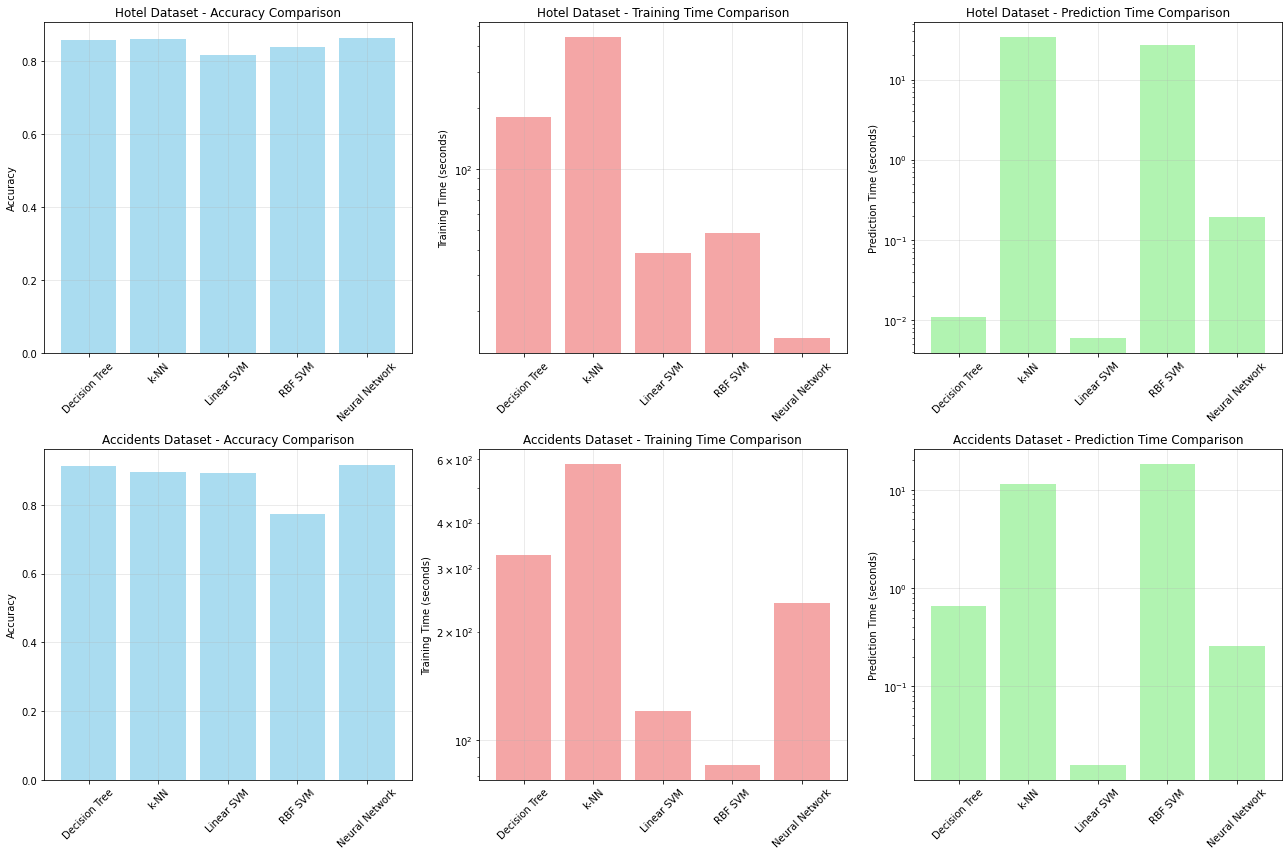

In [75]:
hotel_results = pd.DataFrame({
    'Algorithm': ['Decision Tree', 'k-NN', 'Linear SVM', 'RBF SVM', 'Neural Network'],
    'Accuracy': [dt_hotel_accuracy, hotel_knn_accuracy, hotel_linear_accuracy, hotel_rbf_accuracy, hotel_nn_accuracy],
    'Precision': [dt_hotel_precision, hotel_knn_precision, hotel_linear_precision, hotel_rbf_precision, hotel_nn_precision],
    'Recall': [dt_hotel_recall, hotel_knn_recall, hotel_linear_recall, hotel_rbf_recall, hotel_nn_recall],
    'F1-Score': [dt_hotel_f1, hotel_knn_f1, hotel_linear_f1, hotel_rbf_f1, hotel_nn_f1],
    'ROC-AUC': [dt_hotel_roc_auc, hotel_knn_roc_auc, np.nan, hotel_rbf_roc_auc, hotel_nn_roc_auc],
    'PR-AUC': [dt_hotel_pr_auc, hotel_knn_pr_auc, np.nan, average_precision_score(hotel_y_test, hotel_rbf_pred_proba), hotel_nn_pr_auc],
    'Train_Time': [dt_hotel_total_train_time, knn_hotel_total_train_time, linear_hotel_tuning_time, rbf_hotel_train_time, nn_hotel_fit_time],
    'Predict_Time': [dt_hotel_pred_time, knn_hotel_pred_time, linear_hotel_pred_time, rbf_hotel_pred_time, nn_hotel_pred_time]
})

print(hotel_results)

accidents_results = pd.DataFrame({
    'Algorithm': ['Decision Tree', 'k-NN', 'Linear SVM', 'RBF SVM', 'Neural Network'],
    'Accuracy': [accidents_dt_accuracy, accidents_knn_accuracy, accidents_linear_accuracy, accidents_rbf_accuracy, accidents_nn_accuracy],
    'Precision': [accidents_dt_precision, accidents_knn_precision, accidents_linear_precision, accidents_rbf_precision, accidents_nn_precision],
    'Recall': [accidents_dt_recall, accidents_knn_recall, accidents_linear_recall, accidents_rbf_recall, accidents_nn_recall],
    'F1-Score': [accidents_dt_f1, accidents_knn_f1, accidents_linear_f1, accidents_rbf_f1, accidents_nn_f1],
    'ROC-AUC': [accidents_dt_roc_auc, accidents_knn_roc_auc, np.nan, accidents_rbf_roc_auc, accidents_nn_roc_auc],
    'Train_Time': [dt_accidents_total_train_time, knn_accidents_total_train_time, linear_accidents_tuning_time, rbf_accidents_train_time, nn_accidents_fit_time],
    'Predict_Time': [dt_accidents_pred_time, knn_accidents_pred_time, linear_accidents_pred_time, rbf_accidents_pred_time, nn_accidents_pred_time]
})

print(accidents_results)

print(accidents_results)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

algorithms = ['Decision Tree', 'k-NN', 'Linear SVM', 'RBF SVM', 'Neural Network']

axes[0, 0].bar(algorithms, hotel_results['Accuracy'], alpha=0.7, color='skyblue')
axes[0, 0].set_title('Hotel Dataset - Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(algorithms, hotel_results['Train_Time'], alpha=0.7, color='lightcoral')
axes[0, 1].set_title('Hotel Dataset - Training Time Comparison')
axes[0, 1].set_ylabel('Training Time (seconds)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].bar(algorithms, hotel_results['Predict_Time'], alpha=0.7, color='lightgreen')
axes[0, 2].set_title('Hotel Dataset - Prediction Time Comparison')
axes[0, 2].set_ylabel('Prediction Time (seconds)')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].bar(algorithms, accidents_results['Accuracy'], alpha=0.7, color='skyblue')
axes[1, 0].set_title('Accidents Dataset - Accuracy Comparison')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(algorithms, accidents_results['Train_Time'], alpha=0.7, color='lightcoral')
axes[1, 1].set_title('Accidents Dataset - Training Time Comparison')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].bar(algorithms, accidents_results['Predict_Time'], alpha=0.7, color='lightgreen')
axes[1, 2].set_title('Accidents Dataset - Prediction Time Comparison')
axes[1, 2].set_ylabel('Prediction Time (seconds)')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_yscale('log')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()